In [18]:
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.11.0


In [2]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Train shape: {train_images.shape}")
    print(f"Test shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels, class_names

train_images, train_labels, test_images, test_labels, class_names = load_data()

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [3]:
def preprocess_data(train_images, test_images):
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    return train_images, test_images

train_images, test_images = preprocess_data(train_images, test_images)

In [4]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [39]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr


def k_fold_cross_validation(k, train_images, train_labels, learning_rate, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    num_val_samples = len(train_images) // k
    all_scores = []
    all_loss = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_images[:i * num_val_samples],
            train_images[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_labels[:i * num_val_samples],
            train_labels[(i + 1) * num_val_samples:]],
            axis=0)
        model = create_model()
        # use optimizer based on the input
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        model.compile(optimizer=opt,
                    loss=loss,
                    metrics=metrics)
        model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=[callback])
        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_acc)
        all_loss.append(val_loss)
    return all_scores, all_loss



def plot_k_fold_cross_validation(all_scores):
    # bar chart of accuracy
    min = np.min(all_scores)
    max = np.max(all_scores)
    delta = max - min
    plt.bar(range(len(all_scores)), all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('Folds')
    plt.ylabel('Accuracy')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_scores)))
    plt.show()
    # boxplot
    sns.boxplot(all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('10 folds')
    plt.ylabel('Accuracy')
    # no ticks
    plt.xticks([])
    plt.show()


def plot_k_fold_cross_validation_loss(all_loss):
    min = np.min(all_loss)
    max = np.max(all_loss)
    delta = max - min
    plt.bar(range(len(all_loss)), all_loss)
    plt.title('Loss Scores')
    plt.xlabel('Folds')
    plt.ylabel('Loss')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_loss)))
    plt.show()

In [25]:

all_scores, all_loss = k_fold_cross_validation(10, train_images, train_labels, learning_rate=0.001, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


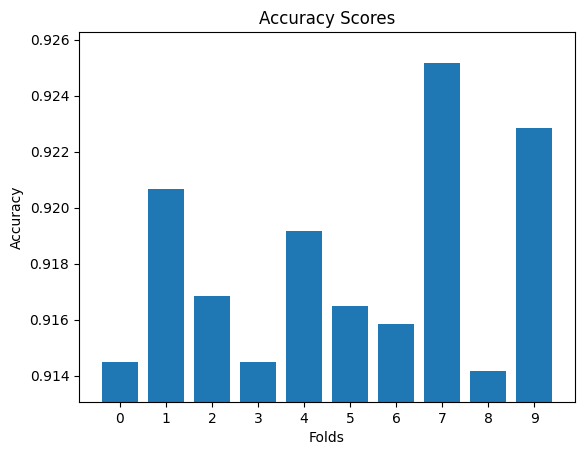

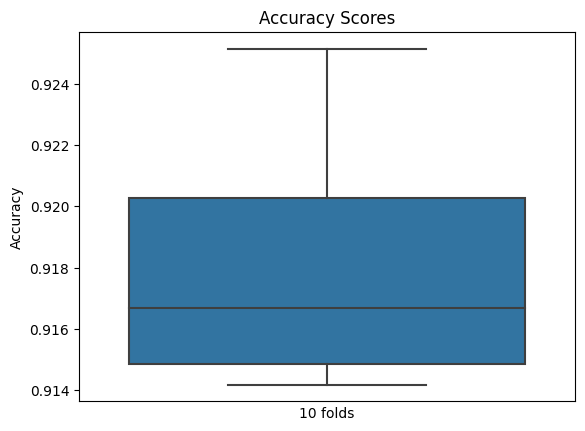

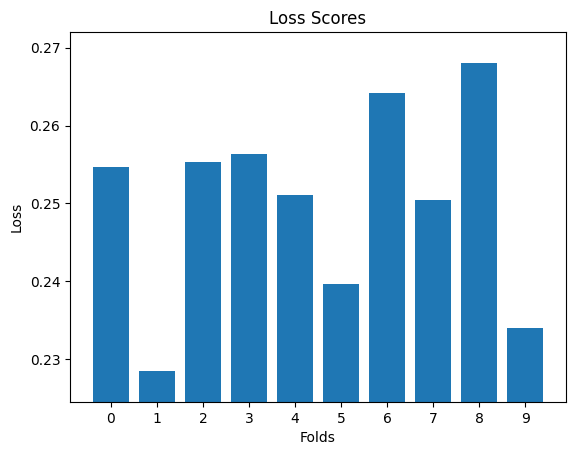

In [40]:
plot_k_fold_cross_validation(all_scores)
plot_k_fold_cross_validation_loss(all_loss)

In [6]:
# Train the model
def train_model(train_images, train_labels):
    model = create_model()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=15, batch_size=64, callbacks=[callback])
    return model, history

model, history = train_model(train_images, train_labels)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

2023-03-16 01:38:20.573371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 01:38:20.598829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 01:38:20.598891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-16 01:38:20.599655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Epoch 1/15


2023-03-16 01:38:27.449426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-16 01:38:29.405248: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 01:38:30.480452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-16 01:38:30.486030: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7f92a91480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-16 01:38:30.486068: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-16 01:38:30.493611: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-16 01:38:30.65162

938/938 [==============================] - 15s 7ms/step - loss: 0.5446 - accuracy: 0.7976 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.3467 - accuracy: 0.8730 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 7s 7ms/step - loss: 0.2947 - accuracy: 0.8913 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 7s 7ms/step - loss: 0.2601 - accuracy: 0.9044 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 7s 7ms/step - loss: 0.2358 - accuracy: 0.9132 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 6s 7ms/step - loss: 0.1949 - accuracy: 0.9279 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 7s 7ms/step - loss: 0.1817 - accuracy: 0.9332 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 7s 7ms/step - loss: 0.1692 - accuracy: 0.9372 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 7s 7ms/step - loss: 0.1570 - accuracy: 0

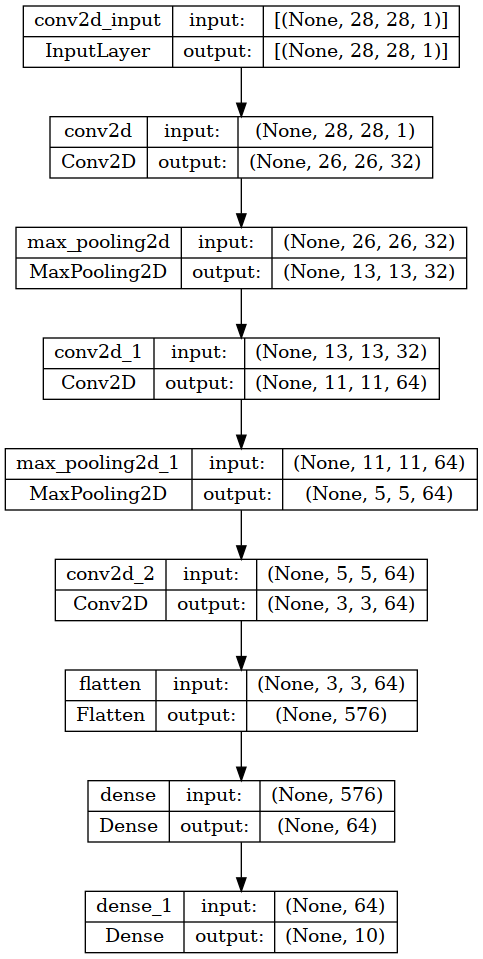

In [7]:
# plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [43]:
history.history

{'loss': [0.5446245670318604,
  0.34665629267692566,
  0.29466739296913147,
  0.26007556915283203,
  0.23577354848384857,
  0.19489367306232452,
  0.18169748783111572,
  0.1692112237215042,
  0.15699408948421478,
  0.14665815234184265,
  0.12285803258419037,
  0.1155339777469635,
  0.10848728567361832,
  0.10292582213878632,
  0.09688658267259598],
 'accuracy': [0.7976499795913696,
  0.8730166554450989,
  0.8913333415985107,
  0.9043999910354614,
  0.913183331489563,
  0.9278666377067566,
  0.9332000017166138,
  0.9372333288192749,
  0.9418333172798157,
  0.9452166557312012,
  0.9546499848365784,
  0.9589166641235352,
  0.9607999920845032,
  0.9634166955947876,
  0.9657666683197021],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0005,
  0.0005,
  0.0005,
  0.0005,
  0.0005,
  0.00025,
  0.00025,
  0.00025,
  0.00025,
  0.00025]}

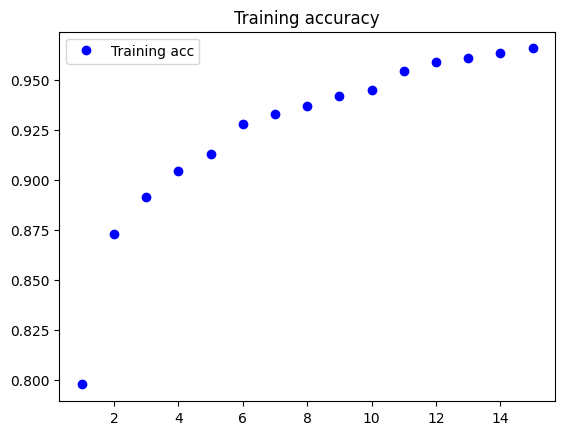

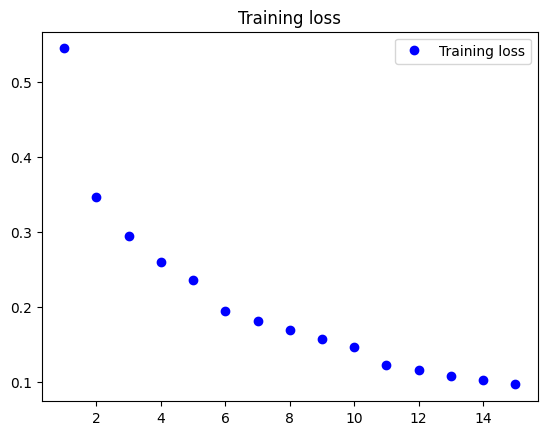

In [44]:
# plot loss and accuracy
def plot_loss_and_accuracy(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

plot_loss_and_accuracy(history)